## Sentiment Classification using Pretrained LSTM
In this notebook, we will leverage a pretrained LSTM model trained on language modeling on the IMDB dataset.
We will fine-tune this model for sentiment classification, a supervised learning task.

### **Why Pretraining is Important:**
Pretraining allows the model to learn general language representations from a large amount of unlabeled text data. These representations can then be adapted to specific downstream tasks (like sentiment classification) with less labeled data and training time. Pretraining provides:
- A better initialization for the model parameters.
- Faster convergence during fine-tuning.
- Improved performance on downstream tasks.




In [ ]:
#!pip install datasets

### Dataset Loading

For this task, we use the IMDB dataset, which is a collection of movie reviews labeled as positive or negative.



In [ ]:
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datasets

train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_text=[sample['text'] for sample in train_data]

### Tokenization and Vocabulary Creation
Tokenization is the process of splitting text into smaller units, such as words or subwords.

After tokenization, we build a vocabulary. The vocabulary maps tokens to unique indices, which will be used as input to the model.

In [ ]:
from collections import Counter
class Tokenizer:
  def __init__(self, stop_words, puncts, truncation_size=256  ):

    self.stop_words=stop_words
    self.puncts=puncts
    self.df = {}
    self.truncation_size=truncation_size
  def format_string(self, text):
      tokens=[ token for token  in text.lower().split() if not ((token in self.stop_words) or  (token in self.puncts))   ]
      return tokens

  def tokenize(self, text, truncation=False):
      tokens=self.format_string(text)
      tmp=[]
      for token in tokens:
          if token in self.w2i :
              tmp.append(self.w2i[token])
          else:
              tmp.append(self.w2i['<unk>'])

      if truncation:
          tmp=tmp[: self.truncation_size]
          output= np.ones(self.truncation_size )*self.w2i['<pad>']
          #output[0]=self.w2i['<bos>']
          #output[-1]=self.w2i['<eos>']
          output[: len(tmp)]=tmp
          return list(output), len(tmp)
      else:
          return tmp, len(tmp)
  def detokenize(self, idxs):
      words=[self.i2w[idx] for idx in idxs]

      return ''.join(word+' ' for word in words )
  def fit(self, train_text):
    for text in train_text:
        tokens=self.format_string(text)
        for token, count in Counter(tokens).items():
            if token in self.df:
                self.df[token]+=count
            else:
                self.df[token]=count
    self.w2i={}
    idx_count=0
    for  (k,v) in  self.df.items():
        if v>5:
          self.w2i[k]=idx_count
          idx_count+=1

    for k in ['<unk>', '<pad>', '<bos>', '<eos>']:
      self.w2i[k]=idx_count
      idx_count+=1


    self.i2w = { v:k for (k,v) in  self.w2i .items() }


In [ ]:
stop_words= []
puncts=  []

In [ ]:
tokenizer=Tokenizer(stop_words , puncts)
tokenizer.fit(train_text)

### Dataset Creation
We create a PyTorch dataset by converting tokenized text into sequences of token indices.
Padding ensures that all sequences in a batch have the same length.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train_data, tokenizer, return_type='Ids'):
        """
        Initialize the dataset with data and targets.
        Args:
            data: The input data (e.g., features).
            targets: The corresponding labels or targets.
        """
        self.train_data = train_data
        self.tokenizer = tokenizer
        self. return_type=return_type # BoG, Tf-Idf Ids
    def __len__(self):
        """
        Return the total number of samples.
        """
        return len(self.train_data)

    def __getitem__(self, idx):
        """
        Retrieve a sample and its target at the given index.
        """
        text,label= self.train_data[idx]['text'], self.train_data[idx]['label']

        if self.return_type=='Ids'  :
            idxs, length=self.tokenizer.tokenize(text, truncation=True)
            idxs= np.array(idxs).astype('int32')
            return idxs, length, label
        elif self.return_type=='BoG':
            vec=np.zeros(len(self.tokenizer.w2i))
            idxs= self.tokenizer.tokenize(text)
            for idx in idxs:
                vec[idx]+=1
            return vec, label
        else:
            tf=np.zeros(len(self.tokenizer.w2i))
            idxs= self.tokenizer.tokenize(text)
            for idx in idxs:
                tf[idx]+=1
            tf/=len(idxs)

            for i in range(len(tf)):
                tf[i]*=self.tokenizer.idf[i]
            return tf, label

In [ ]:
train_dataset = CustomDataset(train_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)

In [ ]:
train_dataset[3]

(array([   33,   153,    16,   329,   330,    25,   331, 40131, 40131,
           85,     0,   332,   265,    31,    43,    12,   153,   333,
           46,    47,   153,    98,   334,   335,   336,    85,   217,
          337,   338,    10,   339,   340,   341,    10,   342,   343,
          344, 40131,   345,     3,   346,    75,   347,   106,   348,
           49,    10,   349,   350,     8,   351,    57, 40131,    98,
           31,   163,   348,   352,   353,    19,    10,   354,    62,
          355,   303,   356,    85,   100,     9,    10,   111,    19,
           33, 40131, 40131,   357,    31,   331,   358, 40131,    98,
          359,   360,   100,   361,   307,   362,   363,   115,    74,
           33,   364,     0,   365,   366,    12,   367,     3,    10,
          252,    19,   368,    89,    10,   369,    85,    10,    53,
          370,    46,   371,   372,     8,   373,   374,    85,   375,
          376, 40132, 40132, 40132, 40132, 40132, 40132, 40132, 40132,
      

In [ ]:
train_dataset[3][0][:10]

array([   33,   153,    16,   329,   330,    25,   331, 40131, 40131,
          85], dtype=int32)

In [ ]:


tokenizer.detokenize(train_dataset[3][0])

"this film was probably inspired by godard's <unk> <unk> and i urge you to see that film instead.<br /><br />the film has two strong elements and those are, (1) the realistic acting (2) the impressive, undeservedly good, <unk> apart from that, what strikes me most is the endless stream of silliness. lena <unk> has to be most annoying actress in the world. she acts so stupid and with all the nudity in this <unk> <unk> comparing to godard's film, <unk> has been replaced with stupidity. without going too far on this subject, i would say that follows from the difference in ideals between the french and the swedish society.<br /><br />a movie of its time, and place. 2/10. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

### DataLoader Creation
DataLoaders in PyTorch help in batching and shuffling the data for training and evaluation.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### PyTorch Model Creation
We define an LSTM-based model for text classification. The model consists of:
- An Embedding layer to convert token indices to dense vectors.
- An LSTM layer to capture sequential patterns in the text.
- A fully connected layer for classification.

In [ ]:
class LM(torch.nn.Module):

    def __init__(self, embedding_size, vocab_size, hidden_size, pad_index):
        super(LM, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, padding_idx=pad_index)
        self.lstm= nn.LSTM(embedding_size, hidden_size, num_layers=1, dropout=0.25, batch_first=True)

        self.cls= nn.Linear(hidden_size, vocab_size)


    def forward(self, idxs):
        x = self.embedding (idxs)
        hidden_states, (hn, cn)= self.lstm(x)
        predictions= self.cls(hidden_states)
        return predictions
    def sent_ebedding(self, idxs, lengths, pooling_type='mean'):

      bs,seq_len =idxs.shape
      x = self.embedding (idxs)
      hidden_states, (hn, cn)= self.lstm(x)

      if pooling_type=='none':
        ret=[]
        for i in range(bs):
              ret.append(hidden_states[i, lengths[i]-1,])
      else:
        ret = [
        torch.sum(hidden_states[i, :l, :], dim=0) / l for i, l in enumerate(lengths)
       ]
      return torch.stack(ret)



In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self, output_dim, embedding_size, vocab_size, hidden_size, pad_index, dropout_rate=0.25):
        super(Classifier, self).__init__()

        self.lm = LM(embedding_size, vocab_size, hidden_size, pad_index)
        self.dropout = nn.Dropout(dropout_rate)
        self.cls= nn.Linear(hidden_size, output_dim)


    def forward(self, idxs, lengths):

        sent_emb =self.dropout(self.lm.sent_ebedding(idxs, lengths))

        predictions= self.cls(sent_emb)
        return predictions

In [ ]:

hidden_size=256
embedding_size=300
vocab_size=len(tokenizer.w2i)
pad_index=tokenizer.w2i['<pad>']


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Classifier(1, embedding_size, vocab_size, hidden_size, pad_index).to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


In [ ]:
#!gdown --id 1xe0oDV5TNml_3XonkrhLzRZ1QO4XAw9A

### Loading Pretrained Model
We load the pretrained LSTM weights into the current model to leverage the knowledge gained from language modeling.

In [ ]:
import os
if os.path.isfile('pretrained_lstm.pth'):
  model.lm.load_state_dict(torch.load('pretrained_lstm.pth'))

<ipython-input-17-19fd2cbe0c71>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.lm.load_state_dict(torch.load('pretrained_lstm.pth'))


### Optimizer and Loss Creation
We use:
 - CrossEntropyLoss for classification.
 - Adam optimizer for faster convergence.

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters())


### Training the Model
We fine-tune the pretrained model on the sentiment classification task.
The training loop includes:
- Forward pass: Compute predictions.
- Loss computation: Calculate the difference between predictions and ground truth.
- Backward pass: Update model parameters using gradients.

In [ ]:
def train_one_epoch(epoch_index, training_loader, loss_fn, print_every=100):

    running_loss = []

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, lengths, labels=batch
        inputs, labels=inputs.to(device).long(), labels.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs, lengths)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.reshape(-1), labels.reshape(-1))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss.append(loss.item())
        if i % print_every == (print_every-1):
            last_loss =  np.mean(running_loss) # loss per batch
            print('Train {}  batch {} / {} loss: {}'.format(epoch_index, i + 1, len(training_loader), last_loss))



    return np.mean(running_loss)

In [ ]:
def test_one_epoch(epoch_index, testing_loader, loss_fn, print_every=100):
    running_loss = []


    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(testing_loader):
        # Every data instance is an input + label pair
        inputs, lengths, labels=batch
        inputs, labels=inputs.to(device).long(), labels.to(device).float()



        # Make predictions for this batch
        with torch.no_grad():
          outputs = model(inputs, lengths)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.reshape(-1), labels.reshape(-1))

        # Gather data and report
        running_loss.append(loss.item())
        if i % print_every == (print_every-1):
            last_loss = np.mean(running_loss) # loss per batch
            print('Test epoch {} batch {} / {} loss: {}'.format(epoch_index, i + 1, len(testing_loader), last_loss))


    return np.mean(running_loss)

In [ ]:
from tqdm.notebook import tqdm

best_test_loss=np.inf
train_loss=[]
test_loss=[]
n_epochs=10
for epoch in range(n_epochs):

  model.train()

  last_loss= train_one_epoch(epoch, train_dataloader, criterion)
  train_loss.append(last_loss)

  model.eval()
  last_loss= test_one_epoch(epoch, test_dataloader, criterion)
  test_loss.append(last_loss)
  if last_loss < best_test_loss:
    best_test_loss=last_loss
    torch.save(model.state_dict(), 'best_model.pth')


Train 0  batch 100 / 782 loss: 0.6416792878508568
Train 0  batch 200 / 782 loss: 0.5822418129444122
Train 0  batch 300 / 782 loss: 0.5452302766839663
Train 0  batch 400 / 782 loss: 0.5167510155588388
Train 0  batch 500 / 782 loss: 0.4934422794878483
Train 0  batch 600 / 782 loss: 0.4760333736240864
Train 0  batch 700 / 782 loss: 0.4595988820280347
Test epoch 0 batch 100 / 782 loss: 0.1881713183969259
Test epoch 0 batch 200 / 782 loss: 0.18451315313577651
Test epoch 0 batch 300 / 782 loss: 0.18785597026348114
Test epoch 0 batch 400 / 782 loss: 0.19348619299009442
Test epoch 0 batch 500 / 782 loss: 0.27770273126661776
Test epoch 0 batch 600 / 782 loss: 0.3337167793139815
Test epoch 0 batch 700 / 782 loss: 0.37746976840708935
Train 1  batch 100 / 782 loss: 0.20145737785845996
Train 1  batch 200 / 782 loss: 0.20464295823127032
Train 1  batch 300 / 782 loss: 0.20620900765061378
Train 1  batch 400 / 782 loss: 0.2084718249551952
Train 1  batch 500 / 782 loss: 0.2109356636106968
Train 1  batch

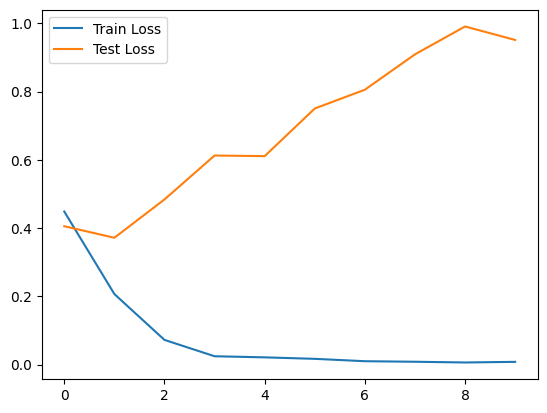

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-32-97ca0473330f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

### Model Evaluation
After training, we evaluate the model on the test dataset to measure its accuracy on unseen data.

In [ ]:
gt, preditions=[] , []
for   batch in tqdm(test_dataloader):
        # Every data instance is an input + label pair
        inputs, lengths, labels=batch
        inputs, labels=inputs.to(device).long(), labels



        # Make predictions for this batch
        with torch.no_grad():
          outputs = (torch.sigmoid(model(inputs, lengths).reshape(-1))>=0.5).detach().cpu().numpy()

        gt.extend(labels.numpy())
        preditions.extend(outputs*1)

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
gt, predition=np.array(gt), np.array(preditions)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(gt,predition )

array([[ 9739,  2761],
       [ 1157, 11343]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gt, predition, target_names=['Pos','Neg']))

              precision    recall  f1-score   support

         Pos       0.89      0.78      0.83     12500
         Neg       0.80      0.91      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000

